# Import Libraries

In [1]:
# Mengunduh lbraries yang dibutuhkan
%pip install transformers
%pip install Sastrawi
%pip install emoji

# Mengunduh / clone repository
!git clone https://github.com/rifqimaruf/indonlu.git

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 1.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Cloning into 'indonlu'...
remote: Enumerating objects: 500, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 500 (delta 115), reused 139 (delta 110), pack-reused 316 (from 1)
Receiving objects: 100% (500/500), 9.45 MiB | 20.77 MiB/s, done.
Resolving deltas: 100% (235/235), done.


In [2]:
# libraries untuk data processing
import pandas as pd
import numpy as np
import random
import re
from sklearn.model_selection import train_test_split, StratifiedKFold 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from IPython.display import display, HTML
from collections import defaultdict

# Melakukan visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

# Natural Language Processing Libraries
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from collections import defaultdict
import emoji

# Melaukan Handling Imbalance Dataset
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import RandomOverSampler

# Deep Learning libraries untuk Model IndoBERT
import torch
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader
from torch import optim
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import OneCycleLR



# Transformers libraries untuk IndoBert
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer, BertModel

# IndoNLU utilities untuk Sentiment Analysis
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn

import time

# Download libraries tokenizer dan stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Menghapus folder yang sudah ada 
import shutil
# shutil.rmtree('/kaggle/working/indonlu')

# Data Loading

In [4]:
# Membaca dataset Pemilu dan BBM
pemilu_df = pd.read_csv("/kaggle/input/pemilu/pemilu_raw.csv")
bbm_df = pd.read_csv("/kaggle/input/pemilu/kenaikan_bbm_raw.csv")

# Menampilkan beberapa baris dari dataframe
print("Pemilu DataFrame:")
display(pemilu_df.head())

print("BBM DataFrame:")
display(bbm_df.head())

Pemilu DataFrame:


,Hasil,Tweet,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,0,barusan liat tulisan di belakang truk rela inj...,NaN,NaN,NaN
1,0,her itu lho miss kevin sama keven rebutan gimb...,NaN,NaN,NaN
2,0,iya rep gatau aku masih kelas 4 sd ehh di block,NaN,NaN,NaN
3,0,aku mohon tepatilah janjimu penantiancintaeps19,NaN,NaN,NaN
4,0,bukan beria nk kahwin sbb gatal celah kangkang...,NaN,NaN,NaN


BBM DataFrame:


,sentimen,text
0,NETRAL,@tanyarlfes Gaada bukti tapi dulu gw kalo nget...
1,NETRAL,@pcogovph Kayang kaya talaga paikutin ni Digon...
2,NEGATIF,@kpktemananies @musniumar Bajingany di mna om ...
3,NEGATIF,@m8deman @lovelyb1e Km yg ngomong ini pasti kr...
4,NEGATIF,@OposisiCerdas @venasantika Gaji besar bukanny...


In [5]:
# Melakukan penghapusan kolom yang tidak digunakan
pemilu_df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace=True)

# Mengganti representasi nilai kolom sentimen
pemilu_df['Hasil'] = pemilu_df['Hasil'].replace({0: 'neutral', 1: 'positive', -1: 'negative'})
bbm_df['sentimen'] = bbm_df['sentimen'].replace({"NETRAL": 'neutral', "POSITIF": 'positive', "NEGATIF": 'negative'})

# Mengganti nama kolom untuk kemudahan proses data
pemilu_df = pemilu_df.rename(columns={"Tweet": "text", "Hasil": "sentiment"})
bbm_df = bbm_df.rename(columns={"sentimen": 'sentiment'})

In [6]:
# Menampilkan beberapa baris dari dataframe
print("Pemilu DataFrame:")
display(pemilu_df.head())

print("BBM DataFrame:")
display(bbm_df.head())

Pemilu DataFrame:


,sentiment,text
0,neutral,barusan liat tulisan di belakang truk rela inj...
1,neutral,her itu lho miss kevin sama keven rebutan gimb...
2,neutral,iya rep gatau aku masih kelas 4 sd ehh di block
3,neutral,aku mohon tepatilah janjimu penantiancintaeps19
4,neutral,bukan beria nk kahwin sbb gatal celah kangkang...


BBM DataFrame:


,sentiment,text
0,neutral,@tanyarlfes Gaada bukti tapi dulu gw kalo nget...
1,neutral,@pcogovph Kayang kaya talaga paikutin ni Digon...
2,negative,@kpktemananies @musniumar Bajingany di mna om ...
3,negative,@m8deman @lovelyb1e Km yg ngomong ini pasti kr...
4,negative,@OposisiCerdas @venasantika Gaji besar bukanny...


# Data Exploration

In [7]:
# 1. Menampilkan ringkasan informasi umum DataFrame 
display(HTML("<h2> Ringkasan Informasi Data Pemilu</h2>\n"))
pemilu_df.info(),
print("===================================================")
display(HTML("<h2> Ringkasan Informasi Data BBM</h2>"))
bbm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42692 entries, 0 to 42691
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  42692 non-null  object
 1   text       42692 non-null  object
dtypes: object(2)
memory usage: 667.2+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7529 entries, 0 to 7528
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  7529 non-null   object
 1   text       7529 non-null   object
dtypes: object(2)
memory usage: 117.8+ KB


In [8]:
# 2. Donat Plot
# Fungsi Donat Plot
def donut(sizes, ax, angle=90, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%', 
           startangle = angle, pctdistance=0.8, explode = explode, 
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')  
    plt.tight_layout()

In [9]:
# Argument plot untuk Pemilu
sizes_pemilu = pemilu_df.sentiment.value_counts()
labels_pemilu = ['Tweet Netral', 'Tweet Negatif', 'Tweet Positif']
colors_pemilu = ['lightgreen', 'lightskyblue', 'lightcoral']
explode_pemilu = (0, 0, 0)

# Argument plot untuk BBM
sizes_bbm = bbm_df.sentiment.value_counts()
labels_bbm = ['Tweet Netral', 'Tweet Negatif', 'Tweet Positif']
colors_bbm = ['lightgreen', 'lightskyblue', 'lightcoral']
explode_bbm = (0, 0, 0)

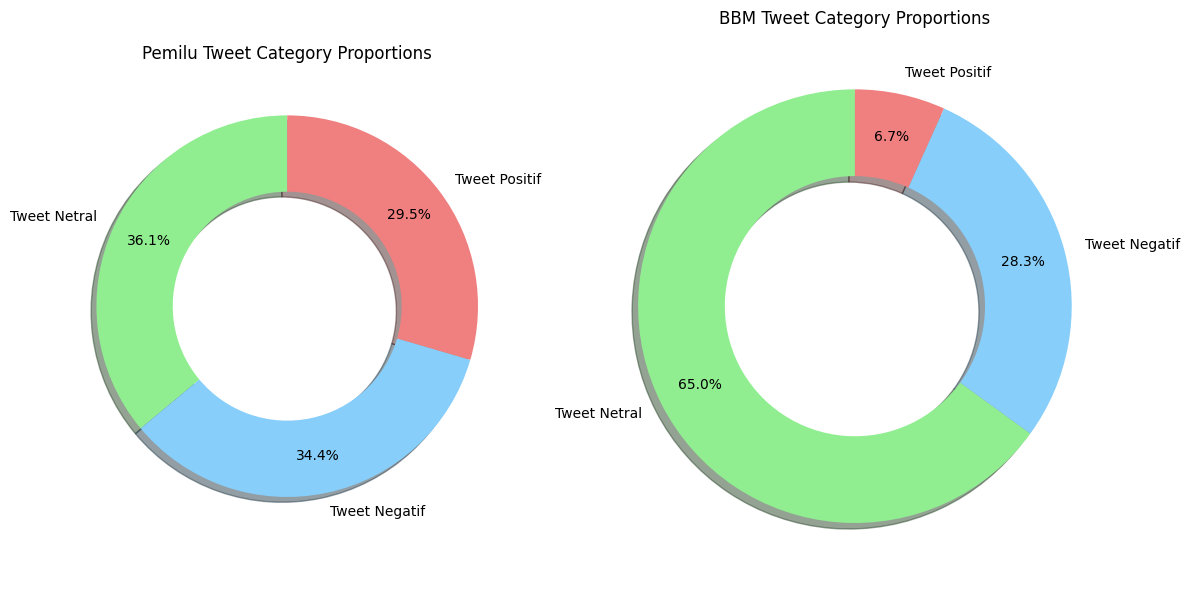

In [10]:
#  Membuat Figure dan Axis untuk dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot donat untuk Pemilu
donut(sizes_pemilu, ax1, 90, labels_pemilu, colors=colors_pemilu, explode=explode_pemilu, shadow=True)
ax1.set_title('Pemilu Tweet Category Proportions')

# Plot donat untuk BBM
donut(sizes_bbm, ax2, 90, labels_bbm, colors=colors_bbm, explode=explode_bbm, shadow=True)
ax2.set_title('BBM Tweet Category Proportions')

# Menampilkan plot
plt.tight_layout()
plt.show()

In [11]:
# 3. Mengecek WordFrequency dan Wordcloud
# Fungsi untuk membuat corpus dari kolom teks
def make_corpus(column):
    corpus_list = [word for text in column for word in text.split(' ')]
    corpus = ' '.join(corpus_list)
    return re.sub(' +', ' ', corpus)  # Mengganti spasi ganda dengan satu spasi

# Fungsi untuk menghitung frekuensi kata
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    df = pd.DataFrame(freqdist.most_common(top), columns=['word', 'freq'])
    return df

In [12]:
# Membuat corpus dan menghitung frekuensi untuk kedua DataFrame
corpus_pemilu = make_corpus(pemilu_df['text'])
corpus_bbm = make_corpus(bbm_df['text'])

corpus_freq_pemilu = word_freq(corpus_pemilu, top=20)
corpus_freq_bbm = word_freq(corpus_bbm, top=20)

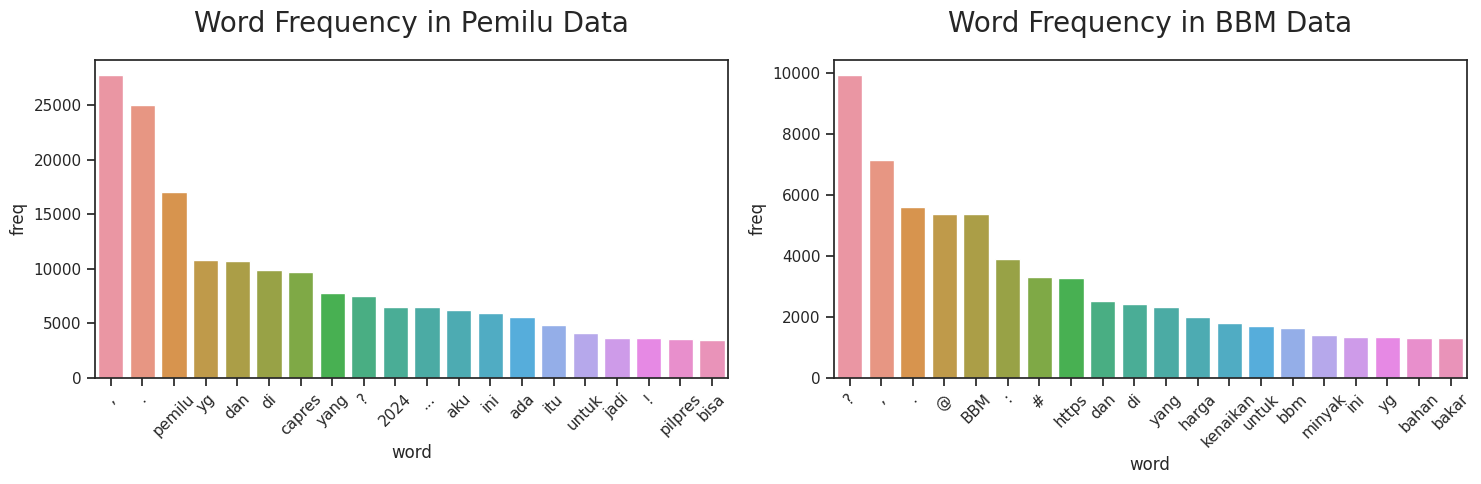

In [13]:
# Mengatur parameter visualisasi
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Membuat figure dengan dua subplot (dua axis)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot frekuensi kata untuk data Pemilu
sns.barplot(x='word', y='freq', data=corpus_freq_pemilu, ax=ax1)
ax1.set_title('Word Frequency in Pemilu Data')
ax1.tick_params(axis='x', rotation=45)

# Plot frekuensi kata untuk data BBM
sns.barplot(x='word', y='freq', data=corpus_freq_bbm, ax=ax2)
ax2.set_title('Word Frequency in BBM Data')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

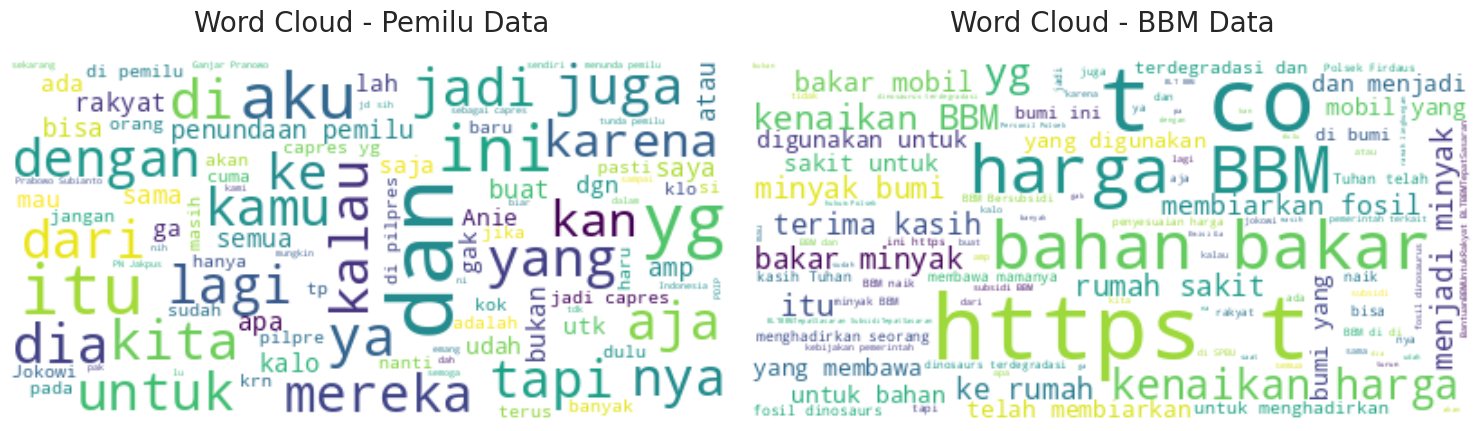

In [14]:
# Membuat WordCloud untuk kedua corpus
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# WordCloud untuk corpus Pemilu
wordcloud_pemilu = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus_pemilu)
ax1.imshow(wordcloud_pemilu, interpolation="bilinear")
ax1.axis("off")
ax1.set_title('Word Cloud - Pemilu Data')

# WordCloud untuk corpus BBM
wordcloud_bbm = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus_bbm)
ax2.imshow(wordcloud_bbm, interpolation="bilinear")
ax2.axis("off")
ax2.set_title('Word Cloud - BBM Data')

plt.tight_layout()
plt.show()

In [15]:
# 4. Mengecek duplikasi value
pemilu_df.duplicated().sum(), bbm_df.duplicated().sum()
pemilu_df.drop_duplicates(inplace=True), bbm_df.drop_duplicates(inplace=True)

(None, None)

In [16]:
# 5. Menampilkan ukuran baris dan kolom DataFrame
pemilu_df.shape, bbm_df.shape

((42122, 2), (7063, 2))

# Preprocessing

## Preprocessing_v1

In [17]:
character = ['.',',',';',':','-,','...','?','!','(',')','[',']','{','}','<','>','"','/','\'','#','-','@',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# hapus karakter yang berulang
def repeatcharClean(text): 
  for i in range(len(character)):
    charac_long = 5
    while charac_long > 2:
      char = character[i]*charac_long 
      text = text.replace(char,character[i])
      charac_long -= 1
  return text

In [18]:
def clean_review(text):
  # ubah text menjadi huruf kecil
  text = text.lower()
  # ubah enter menjadi spasi
  text = re.sub(r'\n', ' ', text)
  # hapus emoji
  text = emoji.demojize(text)
  text = re.sub(':[A-Za-z_-]+:', ' ', text) # delete emoji
  # hapus emoticon
  text = re.sub(r"([xX;:]'?[dDpPvVoO3)(])", ' ', text)
  # hapus link
  text = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", text)
  # hapus usename
  text = re.sub(r"@[^\s]+[\s]?", ' ', text)
  # hapus hashtag
  text = re.sub(r'#(\S+)', r'\1', text)
  # hapus angka dan beberapa simbol
  text = re.sub('[^a-zA-Z,.?!]+',' ',text)
  # hapus karakter berulang
  text = repeatcharClean(text)
  # clear spasi
  text = re.sub('[ ]+',' ',text)
  return text

In [19]:
def preprocess_v1(df):
  df_pp = df.copy()
  df_pp.text = df_pp.text.map(clean_review)

  # Mengganti nilai nan dengan string kosong 
  df_pp['text'] = df_pp['text'].apply(lambda x: np.nan if x == '' else x)

  # Drop rows where 'Tweet' is NaN
  df_pp.dropna(subset=['text'], inplace=True)
  return df_pp

In [20]:
# Melakukan preprocessing pertama
pemilu_df_v1 = preprocess_v1(pemilu_df)
bbm_df_v1 = preprocess_v1(bbm_df)

## Preprocessing_v2

**Slang dict**

In [21]:
def load_slang_dict(file_path):
    slang_dict = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split(':')
            slang_dict[key.strip()] = value.strip()
    return slang_dict

# Load data slang
slang_dict = load_slang_dict('/kaggle/input/pemilu/slang_dict.txt')

In [22]:
# Mengganti kata slang
def replace_slang(text, slang_dict):
    words = text.split()
    replaced_text = ' '.join([slang_dict.get(word, word) for word in words])
    return replaced_text

**Spell Checker**

In [23]:
# Spell checker using textblob
def spell_checker(text):
    text = ' '.join(TextBlob(text).correct() for text in text.split())
    return text

**Stopwrods**


In [24]:
# Inisialisasi Sastrawi StopWordRemover
factory = StopWordRemoverFactory()
stop_words = factory.get_stop_words()

**Stemmer**

In [25]:
# Inisialisasi Sastrawi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [26]:
def preprocess_text(text):
    #  Mengganti kata slang
    text = replace_slang(text, slang_dict)
    
    # Tokenization
    tokens = word_tokenize(text)
    
     # Menghapus stopwords
    tokens = [word for word in tokens if word.lower() not in stop_words]
    
    # Stemming
    tokens = [stemmer.stem(word) for word in tokens]
    
    # Menggabungkan token menjadi string kembali
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

In [27]:
%%time
# Fynction of preprocess 
def preprocess_dataframe(df):
    df['text'] = df['text'].astype(str)
    
    # Inisialisasi tqdm
    tqdm.pandas(desc="Processing Text Data")  
    df['text'] = df['text'].progress_apply(preprocess_text)  
    
    return df

CPU times: user 21 µs, sys: 0 ns, total: 21 µs
Wall time: 25.5 µs


In [28]:
%%time
# Melakukan preprocessing data kedua
pemilu_df_v2 = preprocess_dataframe(pemilu_df_v1)
bbm_df_v2 = preprocess_dataframe(bbm_df_v1)

Processing Text Data: 100%|██████████| 7063/7063 [17:13<00:00,  6.84it/s]

CPU times: user 1h 43min 44s, sys: 9.66 s, total: 1h 43min 54s
Wall time: 1h 43min 51s


In [29]:
# Menghapus baris yang memiliki string kosong atau hanya satu spasi di kolom 'text'
pemilu_df_v2['text'] = pemilu_df_v2['text'].apply(lambda x: np.nan if x.strip() == '' else x)
pemilu_df_v2.dropna(subset=['text'], inplace=True)

bbm_df_v2['text'] = bbm_df_v2['text'].apply(lambda x: np.nan if x.strip() == '' else x)
bbm_df_v2.dropna(subset=['text'], inplace=True)

In [30]:
# Mereset index dan mengecek nilai null untuk dataset Pemilu
pemilu_df_v2 = pemilu_df_v2.reset_index(drop=True)  # Menyimpan hasil reset index
print("Pemilu Dataset - Nilai Null:")
print(pemilu_df_v2.isnull().sum())

# Mereset index dan mengecek nilai null untuk dataset BBM
bbm_df_v2 = bbm_df_v2.reset_index(drop=True)  # Menyimpan hasil reset index
print("\nBBM Dataset - Nilai Null:")
print(bbm_df_v2.isnull().sum())

Pemilu Dataset - Nilai Null:
sentiment    0
text         0
dtype: int64

BBM Dataset - Nilai Null:
sentiment    0
text         0
dtype: int64


In [31]:
# Reordering posisi kolom
pemilu_df_v2 = pemilu_df_v2[['text', 'sentiment']]
bbm_df_v2 = bbm_df_v2[['text', 'sentiment']]

# save dataset
pemilu_df_v2.to_csv('pemilu_data_preprocessed.tsv', sep='\t', index=False)
bbm_df_v2.to_csv('bbm_data_preprocessed.tsv', sep='\t', index=False)